# Social Computing - Summer 2019
# Exercise 6 - Reality Mining

Reality mining is a field of data analysis with focus on the collection of real-world human data. This, for instance, includes movement, other environmental or social data retrieved from different kind of sensors. From the lecture you already know that in reality mining, social signal processing techniques like collecting social data from mobile phones are used. In this exercise, we will use the dataset and method presented in [1] in order to analyze how reality mined data can be used to uncover regular rules and structure in the behavior of individuals as well as infer relationships between them.

The dataset presented in [1] had been collected within the frame of the MIT university over a time span of nine months (from September 2004 to June 2005) and covers information from MIT staff and students. There were 106 participants that contributed to the data collection but not permanently. You will notice that not for every user at all times, sufficient data is present. The information collected is mostly retrieved from the user's phones, including call logs, a device's location status, other Bluetooth devices in proximity, devices within the same cell tower range and surveys answered by the study's subjects. The dataset consists of several components but you are given only the relevant ones which will be explained in-depth within context of the respective problem they will be used for. The aim of this exercise is to use the given data to analyze activity patterns based on a user's location and inferring community structure based on a user's proximity to others.

[1] N. Eagle, A. Pentland: _Reality Mining: Sensing Complex Social Systems._ Personal and Ubiquitous Computing, 10(4), 255-268, 2006. ([PDF](http://realitycommons.media.mit.edu/pdfs/realitymining_old.pdf))

## Imports & Reading The Data
First of all, we need to import a few modules and reading in the data in order for this exercise to work.

In [2]:
import scipy, random, pickle as pkl, numpy as np, pandas as pd, seaborn as sns, scipy as sc, igraph as ig, matplotlib as mpl, matplotlib.pyplot as plt
from collections import Counter
from datetime import datetime, timedelta
from scipy.spatial import distance
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
from sklearn.metrics import precision_recall_fscore_support


# Set paramters for plotting
width = 7
height = width / 1.618
mpl.rcParams['axes.titlesize'] = 28
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 3
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
mpl.rcParams['figure.figsize'] = (width, height)

%matplotlib inline

# Reading in the pickle file
with open('Dataset.pkl', 'rb') as f:
    hourly_locs = pkl.load(f)
    feature_data = pkl.load(f)
    friends_set = pkl.load(f)
    not_friends_set = pkl.load(f)
    friends_survey = pkl.load(f)
    sbj_ids = pkl.load(f)

## Problem 6.1: Activity Patterns

From the data we just read in, the data stored in the variable `hourly_locs` is needed for the current problem. It is a dictionary that contains the locations for each UUID (identifier for a subject's phone) at every hour of the day (0-23). Some subjects only participated in the study for a while, resulting in sparse data for some UUIDs. The locations are given as numbers:
* 0 – no signal
* 1 – at home
* 2 – at work
* 3 – elsewhere
* NaN – phone is off

Since the data collection's duration amounted to several months, the analysis of the subjects' activity patterns is a desirable possibility. The approach in [1] was to create a Hidden Markov Model in order to predict where an individual may be located in the future. We will not compute such a model but we are interested in a precondition of it - the predictability. We want to find out whether the data would be suitable for prediction at all. Therefore, some kind of measurement for information content needs to be used. A classical measure for that is Shannon's entropy given by the following equation:
$$H(x) = - \displaystyle\sum_{i=1}^{n}p(i)\log_2p(i)$$

where $n$ is the number of places and $p(i)$ the respective probability for the $i$-th location in our case.


### Task 1: Entropy Calculation
**Compute the entropy values for all users for the whole duration of the study.** For this purpose, count the occurences of each location for every user and calculate a probabilty distribution of the places. Then implement the formula given above with the just calculated probabilities. As mentioned above, not all UUIDs from 0 to 106 are taken so you should work with an exception here in order to avoid key errors - assign an entropy of -1 if an UUID is missing. Your program's output is supposed to be an entropy list, containing the values for each user.

In [3]:
entropy_list = []

# Loop over all UUIDs
for uuid in range(107):
    try:
        # Calculate frequency for each location
        places_f = Counter([p for p_list in (hourly_locs[uuid][h] for h in range(24))\
                            for p in p_list if not np.isnan(p)])
        
        total_readings = sum(places_f.values());
        entropy = 0
        for place in places_f:
            # Calculate probability for each location
            p = places_f[place] / total_readings
            # Compute entropy based on probabilities
            entropy -= p*np.log(p)
        
        # print high and low entropy users with insightful data (for next exercise):
        num_good_readings = places_f[1] + places_f[2] + places_f[3]
        if num_good_readings > 2000 and (entropy > 1.2 or entropy < 0.8):
             print(uuid, num_good_readings, entropy)
                   
    # If UUID missing
    except:
        # Assign entropy -1
        entropy = -1
        
    entropy_list.append(entropy)
    
print('\nEntropy for each UUID:', entropy_list)

3 2792 1.3069284230270142
22 3370 1.2531448607084898
24 2832 1.2432373461780666
25 2347 1.308990751959857
36 2876 1.2019164118518884
39 2846 0.6971699103600506
49 2109 0.6118614800599222
52 2432 1.2607724182451023
62 2075 0.48621985661947054
77 2254 0.7969983533826956

Entropy for each UUID: [-1, 0.9743147528693494, 0.5485533822666667, 1.3069284230270142, -1, -1, 0.294452228771331, 1.1959458997510761, 1.1166350422124296, 0.8399518816565807, -1, -1, 1.2022650433787387, 1.1735577535260235, 1.0581121956535564, 1.224443645238812, 1.147195222516268, -1, 0.8302522548702373, 1.2973299057805003, 1.3463266725346892, 1.098710229758455, 1.2531448607084898, -1, 1.2432373461780666, 1.308990751959857, 1.0336045502328246, -1, 0.6905983790310668, 0, 1.204063643039921, -1, 0.9478705289424517, 1.0176460008401562, 1.2529144310146545, 1.2640828176784193, 1.2019164118518884, 1.2304358812614826, -1, 0.6971699103600506, 1.0022289301727572, 1.0666887398940368, 0.979094241059987, -1, -1, -1, -1, -1, 0.74595620

### Task 2: Predicability of Activity Patterns
The next step is to compare the daily activities of two different subjects, one with a low entropy and one with a much higher entropy, and observe the differences in the regularity of their patterns. **Choose one subject with a low and another with a high entropy value, get their hourly locations for one month and create a heatmap for each. Describe the subjects' daily activites and the disparities between both subjects. Explain the resulting relationship between entropy and the predictability of an individual's activity patterns.** Do not write more than 5 sentences.<p>

**Notes:**
* Due to the lack of data for some users, their data might not be as insightful on certain months as for other subjects - choose accordingly.
* It is helpful to fill NaN values with -1.0 using pandas `fillna` function.

Legend:
-1 – phone is off
0 – no signal
1 – at home
2 – at work
3 – elsewhere


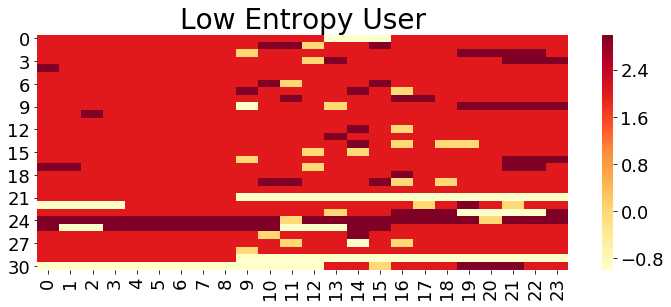

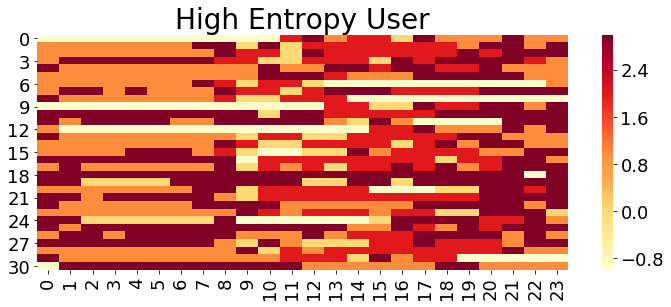

In [4]:
# Low entropy user
uuid = 39
data = pd.DataFrame(hourly_locs[uuid])
data = data.fillna(-1).transpose()
# select only 1 month
data = data.loc[range(0, 31)]

# Create heatmap
cmap = mpl.cm.YlOrRd
fig, ax = plt.subplots(figsize=(1.7*width, height))
ax.set_title('Low Entropy User')
sns.heatmap(data, cmap=cmap, ax=ax)

# High entropy user
uuid = 25
data = pd.DataFrame(hourly_locs[uuid])
data = data.fillna(-1).transpose()
# select only 1 month
data = data.loc[range(0, 31)]

# Create heatmap
cmap = mpl.cm.YlOrRd
fig, ax = plt.subplots(figsize=(1.7*width, height))
ax.set_title('High Entropy User')
sns.heatmap(data, cmap=cmap, ax=ax)

print("Legend:")
print("-1 – phone is off")
print("0 – no signal")
print("1 – at home")
print("2 – at work")
print("3 – elsewhere")

**Your observations here!**

Low entropy users are easy to predict. A good example is user 39, because almost all of his/her readings are at the workplace (maybe he leaves his phone at work). 

High entropy users are harder to predict, as they appear to have no daily patterns. An example of this is user 25. He does not have a fixed work-home schedule, and he is often "elsewhere". There don't seem to be any patterns to his activities.

### Task 3: Prediction Applications

After having discovered the predictability in the first place, one could compute an above mentioned model (e.g. with the help of an HMM as done in [1]) in order to infer the locations of one or more users. **Which applications do these prediction have, what could they be used for? Discuss their advantages and disadvantages.** Don't write more than 5 sentences.

**Your discussion here!**

These activity predictions can be used to do relationship inference, individual behavior modeling or group behavior analysis, and may have many beneficial applications. For example, they could be used to improve traffic on public transportation, or to manage the distribution of any service used by many people in different locations.
The main disadvantage are the privacy concerns of the users, and the possible nefarious usage of private data.

## Problem 6.2: Inferring Friendship - Clustering

Now we want to continue our analysis with the `feature_data` variable read in at the beginning. The goal is to predict whether two people are friends or not using a clustering approach. For that purpose, six features will be used: _Total proximity_, _Saturday night proximity_, _proximity with no signal_, _proximity at home_, _the total number of cell towers together_ and _phone calls per day_. The idea behind it is that the more often two subjects encountered or interacted in a certain way, the more likely they are to know each other better and having some sort of relation (depending on the kind of interaction). The features above seem to be good indicators of friendship since most people will e.g. be spending their weekends (Saturday nights) with friends.

The variable `feature_data` is a dictionary of pandas dataframes for each subject. Each of these dataframes has other subjects as rows, with the following columns (the values were averaged):
* `totalprox` - total encounters with other subjects (min/day)
* `satprox` – encounters with other subjects on a Saturday night (min/week)
* `nosignalprox` – time where other subjects did also not have a signal (min/day)
* `homeprox` – encounters with other subjects at home (min/week)
* `commoncell` – total number of common cell towers for two subjects
* `callevent` – number of phone calls per day from others for each user
* `isfriend` – 1 if the subject considers the other their friend, 0 if not

The last one matches with the variable `friends_survey` that is a dictionary of dicts for each subject, containing the information on who they consider friends. This was collected from actual surveys. The variable `sbj_ids` is a list of subject IDs (identifier for a surveyed person).

**Note**: As mentioned before, not for all subjects enough data was collected so there won't be an entry for those.


### Actual Friends Network
As part of the data collected by [1], subjects answered a survey in which they indicated who they considered close friends. Below, we use the igraph library to plot this network of friends in order to compare it with our predictions later.

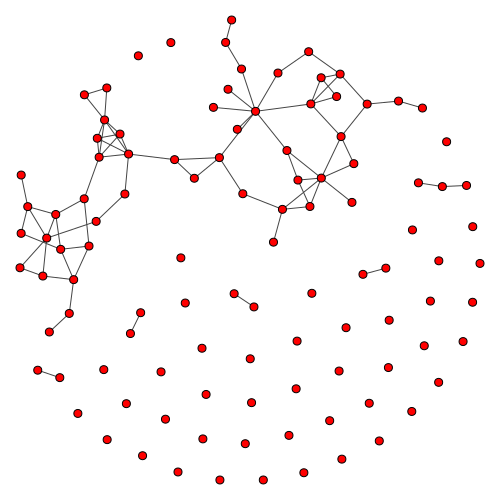

In [5]:
ids_len = len(sbj_ids)
friends_matrix = np.empty((ids_len, ids_len))

# Create adjacency matrix for surveyed friendships
for i, sid in enumerate(sbj_ids):
    friends_matrix[i] = [friends_survey[sid][sid2] for sid2 in sbj_ids]

# Delete self loops
np.fill_diagonal(friends_matrix, 0)

# Create graph from adjacency matrix
g = ig.Graph.Adjacency(list(friends_matrix), mode=ig.ADJ_UNDIRECTED)

visual_style = {}
visual_style['vertex_size'] = 8
visual_style['bbox'] = (500,500)
visual_style['margin'] = 20

ig.plot(g, **visual_style)

### Gaussian Mixture Models & Inferred Network
We will work with a Gaussian mixture model, you should already be familiar with GMMs from the lecture. It is a probabilistic model of several Gaussian distributions whose mixture generate all the data points with unknown parameters. The parameters for a GMM get trained using the **expectation-maximization** (EM) algorithm. You can think of it as generalized k-means clustering but instead of assigning one particular label to each point, each point belongs to each "cluster" with a certain probability. We will apply the clustering approach for each subject and predict their friendship with another person afterwards.

**(1)** Since we have the actual friendship network available, the results can be compared with that network graphically. We are also interested in the accuracy, the proportion of correctly predicted friends. **First of all, complete the code by computing the accuracy. What does the outcome indicate? Compare the actual and the inferred friendship graph.** Don't write more than 3 sentences.

**(2)** As a next step, you are supposed to deal with the [GaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) module. Change the number of compontents in the `GaussianMixture` class constructor to other values. **What reasoning does a GMM use to predict labels? How does the inferred graph change? Can you think of any implications for the distinction of friendships and are there other features suitable to get meaningful information?** Don't write more than 5 sentences.

**Note:** The problematic with predicting labels from a GMM is not knowing what label belongs to which component - we assume the most commonly predicted label is always 'not friends' which is more realistic.

Overall accuracy: 0.8752 +/- 0.1023


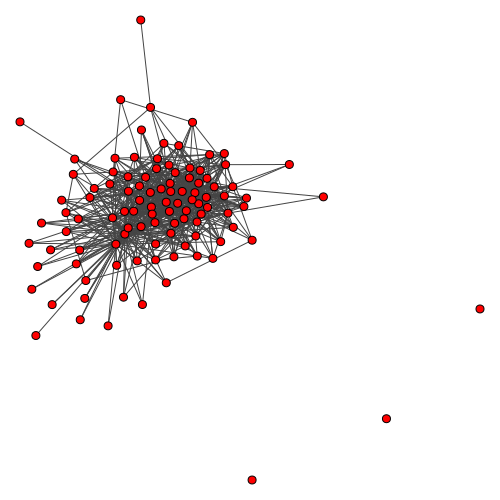

In [11]:
gmm_accuracy = dict()
predictions_dict = dict()
ids_len = len(sbj_ids)-1
gmm_friends_matrix = np.empty((ids_len, ids_len))

# Loop over all subject IDs
for sid in list(feature_data.keys()):
    # Extract the features for current subject
    feature_table = feature_data[sid]
    x = feature_table.ix[:,:'callevent'].values
        
    # Fitting of the GMM to the features

    # TODO: Vary the number of components
    model = GaussianMixture(n_components=2, max_iter=1500)
    model.fit(x)
        
    # Prediction of friendships between current subject and all others
    gmm_pred = model.predict(x)
        
    # Labels (0 or 1) are randomly assigned to 'friends' and 'not friends'
    #  but most common intuitively is the latter
    not_friend = Counter(gmm_pred).most_common()[0][0]
        
    # Create dict for predicted friendships
    predicted = pd.DataFrame({'subject': list(feature_table.index),\
                              'isfriendP': [int(label != not_friend) for label in gmm_pred]})\
                                .set_index('subject')
    predictions_dict[sid] = predicted

    # Evaluate which predictions match the actual friendship
    acc = feature_table.assign(isfriendP = predicted['isfriendP']).pipe(lambda df: df.isfriend == df.isfriendP)
    gmm_accuracy[sid] = acc.value_counts()[True]/ids_len


# Show accuracy for all users
print('Overall accuracy: {:.4f} +/- {:.4f}'.format(pd.Series(gmm_accuracy).mean(), pd.Series(gmm_accuracy).std()))

# Create inferred network (adjacency matrix)
for i, sid in enumerate(sbj_ids):
    try:
        gmm_friends_matrix[i-1] = predictions_dict[sid].isfriendP.values
    except:
        gmm_friends_matrix[i-1] = [0] * ids_len

# Delete self loops
np.fill_diagonal(gmm_friends_matrix, 0)

# Create graph from adjacency matrix
g = ig.Graph.Adjacency(list(gmm_friends_matrix), mode=ig.ADJ_UNDIRECTED)
ig.plot(g, **visual_style)

**Your observations here!**

As expected, the model does not have a very high accuracy: $\approx$87%, which means that for 87% of all pairs of subjects, the model predicted correctly whether or not they were friends.

The GMM aims two represent the data as represented by 2 Gaussians - one for the "non-friends pairs" (chosen to be the one with the highest _a priori_ probability) and one for the "friends pairs". Then, for each feature vector, it tries to predict which Gaussian it was most likely generated from, and thus generate a label for that sample.

The inferred friendship graph is very different from the actual friendship graph - it has a much higher number of edges. The inferred friendship graph resembles the corresponding daily proximity network as represented on the paper. In the friendship graph we have a closely connected group that includes a little less than half the nodes, and we can observe more or less the same amount forming an almost-clique is the inferred friendship graph; likewise, there are about half the nodes which have very few, or no connections.

Varying the number of components of the GMM resulted in worse performance.

We can conclude that the proximity measures considered in the feature vectors are not enough to predict the presence of a friendship.

## Problem 6.3: Inferring Friendship - Classification

Since the clustering approach with Gaussian mixture models only indicates who might be friends, the better option to analyze group affiliation is by using an actual classification approach. There are two classes, those who consider another person their friend (class 1) and those who do not (class 0). For that purpose, we need to built a **generative (Gaussian mixture) model** for each class and classify a new feature vector according to the probabilties these models return. The probabilty for class $c$ given the new vector $x$ and the parameters $\theta$ is:

$$p(y=c \mid x,\theta) \propto p(x \mid y=c, \theta) \cdot p(y=c \mid \theta)$$

where the first term is a **class-conditional density** and the second term a **class prior**. The vector will be assigned the classes' label with the highest probability. The $\propto$-operator means "proportional to" and comes from leaving out the scaling (see Bayes theorem).

The class priors are equivalent to the labels' relative frequencies. To get the class-conditional density, a Gaussian mixture model is fit to a suitbale amount of training data (our six-dimensional feature vectors). This is again done using the EM algorithm. The model yields the component's weights as well as the parameter vector $\theta$, containing each component's means and covariances. The class-conditional density for one class is given by:
$$p(x \mid \theta) = \sum_{k=1}^{K} \pi_{k} \mathcal{N}(x \mid \mu_{k}, \Sigma_{k})$$

where $K$ is the number of mixture components and $\pi_{k}$ the $k$-th component's weight. For more details, refer to the lecture on GMMs.

### Classifier Performance

After building a classifier, it is essential to evaluate how well it actually performs by comparing it with the existent ground truth. A common way to do this is using statistical measures for analysis, e.g. precision, recall or a combined method like the F1 score. They are defined as:

$$P = \frac{TP}{TP + FP}, \hspace{10mm} R = \frac{TP}{TP + FN}, \hspace{10mm}  F_1 = 2 \cdot \frac{P \cdot R}{P + R}$$

Each of these measures is applied _per label_. For the label 'friends' we call it a **true positive** (TP) if a pair was classified as friends when they were, and **false positive** (FP) if classified as friends when they are in fact not. **True/false negatives** (TN, FN) correspondingly refer to not being classified as friends when they were (not). Analogously to the label 'not friends'.

### The Task

For this task, we use the previously read in variables `friends_set` and `not_friends_set` which corresponds to the data in `feature_table` but as a preprocessed format for easier usage in the below classification. The first set contains the people that consider another person their friend and the respective feature values that were already used in Problem 6.2, accordingly for the second set.

**Complete the code in the `GMM_classify` according to the formula given above. Vary the number of components as well as the number of feature vectors for training and testing, and evaluate the resulting classifer using the statistical measures presented above. What is the intuitive meaning for them in our case?** Don't write more than 6 sentences.

**Notes:**
* It might be helpful to look at the class priors when performing different splits.
* The training set has only few entries with class 'friends' since most of the subjects had no affiliation with each other.
* In case of a trivial classifier (one that always assigns one class), the statistical methods won't work well (there will be a warning) so these cases shouldn't be taken into account.

In [222]:
# Calculate the class-conditonal density
def conditional_density(x, GMM):
    prob = 0
    
    # Sum over all mixture components
    for k in range(GMM.n_components):
        # Define the 6-dimensional normal distribution for one component using the GMM parameters
        func = multivariate_normal(mean=GMM.means_[k], cov=GMM.covariances_[k], allow_singular=True)
        
        # Evaluate the function at point x, multiply with component's weight
        prob += GMM.weights_[k] * func.pdf(x)
        
    return prob
    

# Classify the 6-dimensional point x by comparing both GMM evaluations
def GMM_classify(x, GMM_fr, GMM_not_fr, prior_fr, prior_not_fr):
    
    # Compute the conditional densities
    cd_fr     = conditional_density(x, GMM_fr)     * prior_fr
    cd_not_fr = conditional_density(x, GMM_not_fr) * prior_not_fr
    # Return the label with higher probability
    return 1 if cd_fr > cd_not_fr else 0


# Split into training and test data by taking random samples the sets
# TODO: Vary the number of feature vectors
training_fr = list(random.sample(friends_set, 30))

training_not_fr = list(random.sample(not_friends_set, 150))

test = list(friends_set - set(training_fr))\
    + list(random.sample(set(not_friends_set - set(training_not_fr)), 25))


# Compute the relative class frequencies (priors)
num_pairs = len(training_fr) + len(training_not_fr)
prior_fr = len(training_fr) / num_pairs
prior_not_fr = len(training_not_fr) / num_pairs


# Generate GMM for 'friends'
x_fr = np.asarray([tup[0] for tup in training_fr])
GMM_fr = GaussianMixture(n_components=5, max_iter=5000).fit(x_fr)

# Generate GMM for 'not friends'
x_not_fr = np.asarray([tup[0] for tup in training_fr])
GMM_not_fr = GaussianMixture(n_components=12, max_iter=5000).fit(x_not_fr)

estimates = []
ground_truth = []

for x in test:
    
    # Classify the pair x as friends (1) or no friends (0)
    label = GMM_classify(x[0], GMM_fr, GMM_not_fr, prior_fr, prior_not_fr)

    estimates.append(label)
    ground_truth.append(x[1])


# Evaluating the classifier
print(estimates)
print(ground_truth)

performance = precision_recall_fscore_support(y_true=ground_truth, y_pred=estimates)

print('\nPrecision:', performance[0])
print('Recall:', performance[1])
print('F1 score:', performance[2])

[0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Precision: [0.85714286 0.17391304]
Recall: [0.24 0.8 ]
F1 score: [0.375      0.28571429]


**Your observations here!**

Ideally the ratio between the sizes of the training sets (`len(training_fr) / len(training_not_fr)`) should be approximate to the ratio between the sizes of the actual sets (`len(friends_set) / len(not_friends_set)`). However, if this is the case, the prior probability for a pair being friends is too low, and all instances get classified as "not friends". Therefore an equilibrium must be found, and the ratio was set to 1/5. This ratio was also respected for the test set.

Increasing the number of components and feature vectors in the training set improved the classifier's performance, but in the end no good classification performance was achieved

For label "not friends" (0):

- Precision: .85 - 15% of all pairs classified as "not friends" are actually friends.

- Recall: .24 - 24% of all the actual not-friends pairs were identified by the classifier as such.  The high number of false negatives can be in part explained by the change in the ratio between the number of friends and non-friends.

- F1 score: .37 - the harmonic average of precision and recall.

For label "friends" (1), the interpretation of the performance measures is analogous.